In [137]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from tqdm import tqdm_notebook as tqdm
import itertools
import pickle

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from utils import *

bg_color = "#101010"
sns.set_style("darkgrid", {"axes.facecolor": bg_color})
# plt.set_cmap("cool")
# plt.rcParams['font.size'] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
print('Music data: a set of songs characteristics.')

df = pd.read_csv('music.csv', index_col='song.id')
print('Dataset length:', len(df))

_preprocess = False
if _preprocess:
    # Preprocessing
    df.columns = df.columns.map(lambda s: s.replace('.', '_'))
    df.loc[df['year'] == 0, 'year'] = np.nan
    for column in ['artist_name', 'title', 'release_name']:
        df.loc[df[column].isna(), column] = ''
    df['decade'] = 10 * (df.year // 10)
    df.artist_mbtags = df.artist_mbtags.apply(lambda t: shorten_tag(t))\
                    .apply(lambda t: t if t not in tags_inverse_mapping
                           else tags_inverse_mapping[t])
    
    df['title_tokenized'] = df.title.apply(lambda s: clean_tokens(tokenize_flatten(s)))
    df['title_tokenized_length'] = df.title_tokenized.apply(len)
    df['release_name_tokenized'] = df.release_name.apply(lambda s: clean_tokens(tokenize_flatten(s)))
    df['release_name_tokenized_length'] = df.release_name_tokenized.apply(len)
    
    # Cleaning
    columns_to_check = ['title', 'year']
    for ind, g in tqdm(enumerate(df.groupby('artist_name'))):
        temp_df = g[1][columns_to_check]
        for i, (index, row) in enumerate(temp_df.iterrows()):
            title = row.title.upper()
            year = row.year
            for (index2, row2) in temp_df[i+1:].iterrows():
                if (
                    title == row2.title.upper() and 
                    year == row2.year
                ):
                    temp_df = temp_df.drop(index=index2)
                    df = df.drop(index=index2)
    df.to_csv('music_clean.csv')
else:
    df = pd.read_csv('music_clean.csv', index_col='song.id')

print('Dataset length after cleaning:', len(df))
print()
print('An example of the song:')
df.head(1).T

Music data: a set of songs characteristics.
Dataset length: 10000
Dataset length after cleaning: 9962

An example of the song:


song.id,SOMZWCG12A8C13C480
artist_hotttnesss,0.401998
artist_id,ARD7TVE1187B99BFB1
artist_name,Casual
artist_mbtags,NaN
artist_mbtags_count,0
bars_confidence,0.643
bars_start,0.58521
beats_confidence,0.834
beats_start,0.58521
duration,218.932


In [71]:
n_songs, n_albums, n_artists = get_songs_albums_artists(df)
print('{} artists, {} albums and {} songs. But...'.format(n_artists, n_albums, n_songs))
n_songs, n_albums, n_artists = get_songs_albums_artists(df[~df.year.isna()])
print('With known release year: {} artists, {} albums and {} songs.'.format(n_artists, n_albums, n_songs))
from_year, to_year = int(df.year.min()), int(df.year.max())
print('Data collected from {} till {} year.'.format(from_year, to_year))

3887 artists, 8089 albums and 9962 songs. But...
With known release year: 2092 artists, 3887 albums and 4643 songs.
Data collected from 1926 till 2010 year.


In [72]:
# Columns to be analyzed
col = {}
col['artist'] = ['artist_hotttnesss', 'artist_id', 'artist_name', 'familiarity',
                 'artist_mbtags', 'similar']
col['song'] = ['title', 'year', 'release_name']
col['tech'] = ['bars_start', 'bars_confidence',
               'beats_start', 'beats_confidence',
               'duration',
               'start_of_fade_out', 'end_of_fade_in',
               'mode', 'mode_confidence',
               'key', 'key_confidence',
               'loudness',
               'tatums_start', 'tatums_confidence',
               'time_signature', 'time_signature_confidence',
               'terms', 'terms_freq',
               'tempo']
col['location'] = ['location', 'latitude', 'longitude']

In [73]:
# trash
# numeric_columns = df.describe().columns
# other_columns = list(set(df.columns).difference(numeric_columns))

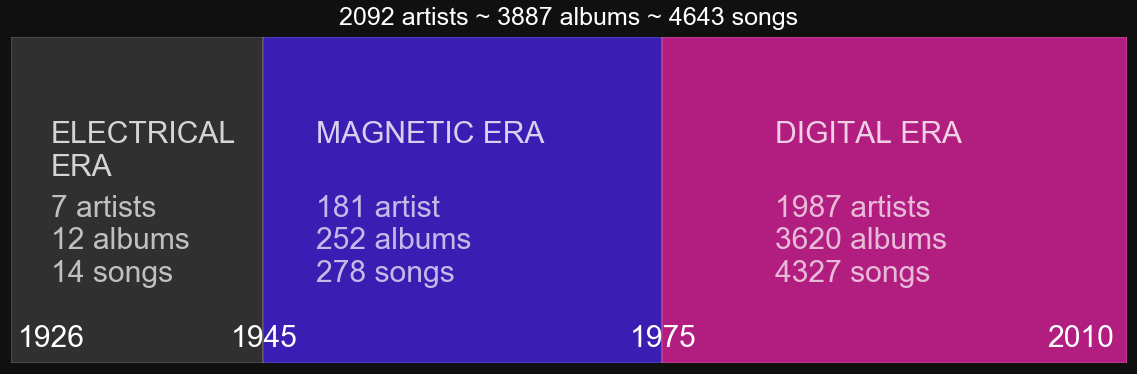

In [213]:
def create_main_vis():
    edge_el_year = 1945
    edge_magn_year = 1975

    df_dig = df[df.year > edge_magn_year]
    n_songs_dig = df_dig.shape[0]
    n_albums_dig = df_dig.release_id.nunique()
    n_artists_dig = df_dig.artist_id.nunique()

    df_magn = df[df.year < edge_magn_year]
    df_magn = df_magn[df_magn.year > edge_el_year]
    n_songs_magn, n_albums_magn, n_artists_magn = get_songs_albums_artists(df_magn)

    df_el = df[df.year < edge_el_year]
    n_songs_el, n_albums_el, n_artists_el = get_songs_albums_artists(df_el)

    mpl.rcParams['figure.figsize'] = (20,6)
    plt.barh(0, edge_el_year-from_year, height=2, left=from_year, color='#303030', linewidth=0.25)
    plt.barh(0, edge_magn_year-edge_el_year, height=2, left=edge_el_year, color='#3A1DB2', linewidth=0.25)
    plt.barh(0, to_year-edge_magn_year, height=2, left=edge_magn_year, color='#B21D80', linewidth=0.25)
    plt.yticks([])
    plt.xticks([])
    plt.ylim(-1, 1)
    plt.xlim(from_year, to_year)
    bottom = -0.9
    center = -0.5
    top = 0.35
    fontsize = 30
    fontsize2 = 30
    plt.annotate(from_year, [from_year+0.5, bottom], color='w', fontsize=fontsize)
    plt.annotate(edge_el_year, [edge_el_year-2.4, bottom], color='w', fontsize=fontsize)
    plt.annotate(edge_magn_year, [edge_magn_year-2.4, bottom], color='w', fontsize=fontsize)
    plt.annotate(to_year, [to_year-6, bottom], color='w', fontsize=fontsize)


    plt.annotate('Electrical\nEra'.upper(), [1929, top-0.2], color='w', fontsize=fontsize, alpha=0.8)
    plt.annotate('{} artists\n{} albums\n{} songs'.format(n_artists_el, n_albums_el, n_songs_el),
                 [1929, center], color='w', fontsize=fontsize2, alpha=0.7)

    plt.annotate('Magnetic Era'.upper(), [1949, top], color='w', fontsize=fontsize, alpha=0.8)
    plt.annotate('{} artist\n{} albums\n{} songs'.format(n_artists_magn, n_albums_magn, n_songs_magn),
                 [1949, center], color='w', fontsize=fontsize2, alpha=0.7)

    plt.annotate('Digital Era'.upper(), [1983.5, top], color='w', fontsize=fontsize, alpha=0.8)
    plt.annotate('{} artists\n{} albums\n{} songs'.format(n_artists_dig, n_albums_dig, n_songs_dig),
                 [1983.5, center], color='w', fontsize=fontsize2, alpha=0.7)
    plt.title('{} artists ~ {} albums ~ {} songs'.format(n_artists, n_albums, n_songs),
              fontsize=25, pad=12)
    
create_main_vis()
template_vis()
plt.savefig('vis_main.png', facecolor=bg_color)
plt.show()

# Artist

Зфокусуємо увагу на такі параметри як `artist_hotttnesss`, `familiarity`, `artist_mbtags`, `similar`, що визначають популярність, стиль музики та схожих виконавців.

In [75]:
# print('Analyzing {}'.format(col['artist']))

# represent_distribution(df.familiarity.dropna(), figsize=(30,10))
# sorted(df.key.unique())
# df[df.key==df.key.max()].T 

In [77]:
def get_df_artist():
    df_artist = df[col['artist']+['year']].drop_duplicates()
    artists_ids = []
    artists_names = []
    hotttnesses = []
    familiarities = []
    mbtags = []
    similars = []
    years = []
    for ind, g in tqdm(enumerate(df_artist.groupby('artist_id'))):
        artists_ids.append(g[0])
        artists_names.append(g[1].artist_name[0])
        hotttnesses.append(g[1].artist_hotttnesss.mean())
        familiarities.append(g[1].familiarity.mean())
        mbtags.append(g[1].artist_mbtags[0])
        similars.append(g[1].similar[0])
        years.append(np.nan if np.isnan(g[1].year.mean()) else int(round(g[1].year.mean())))

    df_artist = pd.DataFrame({'name': artists_names,
                              'hottness': hotttnesses,
                              'familiarity': familiarities,
                              'mbtags': mbtags,
                              'similar': similars,
                              'year': years},
                             index=artists_ids)
    df_artist['decade'] = 10 * (df_artist.year // 10)
    return df_artist

df_artist = get_df_artist()

In [156]:
plt.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = bg_color
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['grid.linewidth'] = 0.5
plt.rcParams['font.size'] = 14
plt.rcParams['text.color'] = 'w'
plt.rcParams['text.alpha'] = 0.8

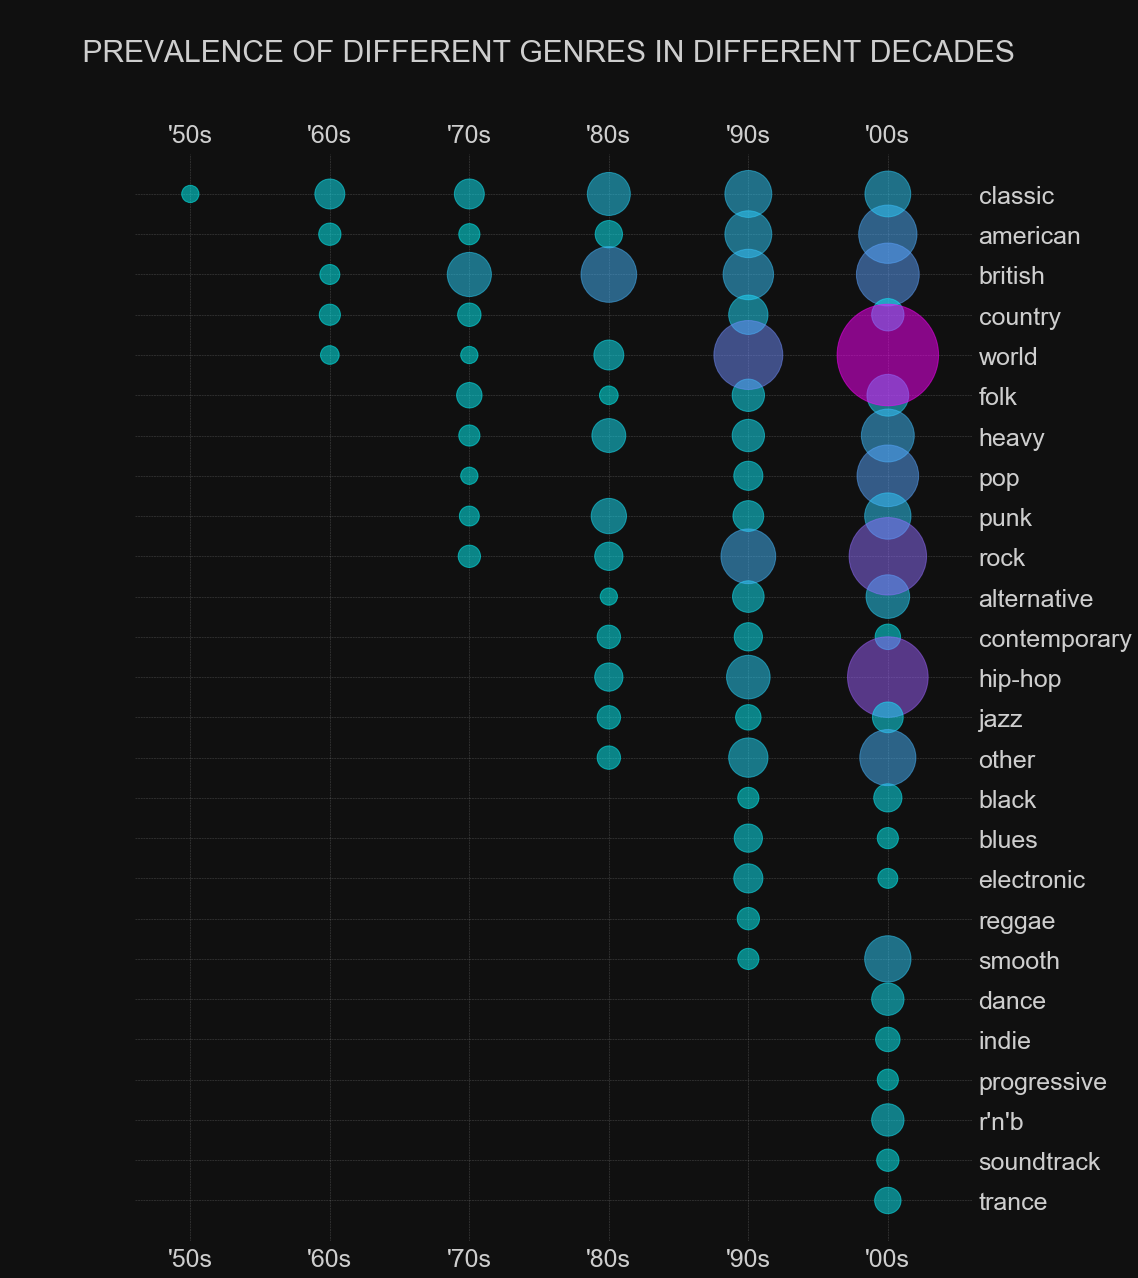

In [212]:
def create_genres_vis(min_freq=5, figsize=(15, 20)):
    xs, ys, sizes = [], [], []
    for g in list(df.groupby(['decade', 'artist_mbtags'])):
        s = len(g[1])
        if s > min_freq:
            xs.append(g[0][0])
            ys.append(g[0][1])
            sizes.append(50*s)
            
    mpl.rcParams['figure.figsize'] = figsize
    template_vis()
    plt.margins(0.04)
    plt.tick_params(top=True, bottom=True, labeltop=True, labelbottom=True,
                    right=True, labelright=True, left=False, labelleft=False)
    plt.gca().grid(which='major', alpha=0.25, linestyle='--')
    
    plt.scatter(xs, ys, s=sizes, c=sizes, cmap='cool', alpha=0.5)
    # Axis
    plt.yticks(fontsize=25, alpha=0.8)
    plt.xticks(np.arange(1940,2020,10), ['\'{:02}s'.format(i%100) for i in np.arange(1940,2020,10)],
               fontsize=25, alpha=0.8)
    plt.gca().xaxis.set_ticks_position('none') 
    plt.gca().yaxis.set_ticks_position('none') 
    plt.gca().invert_yaxis()
    
    # Frame
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlim(left=1946, right=2006)
    plt.title('\n         Prevalence of different genres in different decades'.upper(), x=0.45, y=1.08,
                 fontweight='normal', fontstretch='0', fontsize=30, alpha=0.8)

create_genres_vis(min_freq=5, figsize=(15, 20))
plt.savefig('vis_genres.png', facecolor=bg_color)
plt.show()

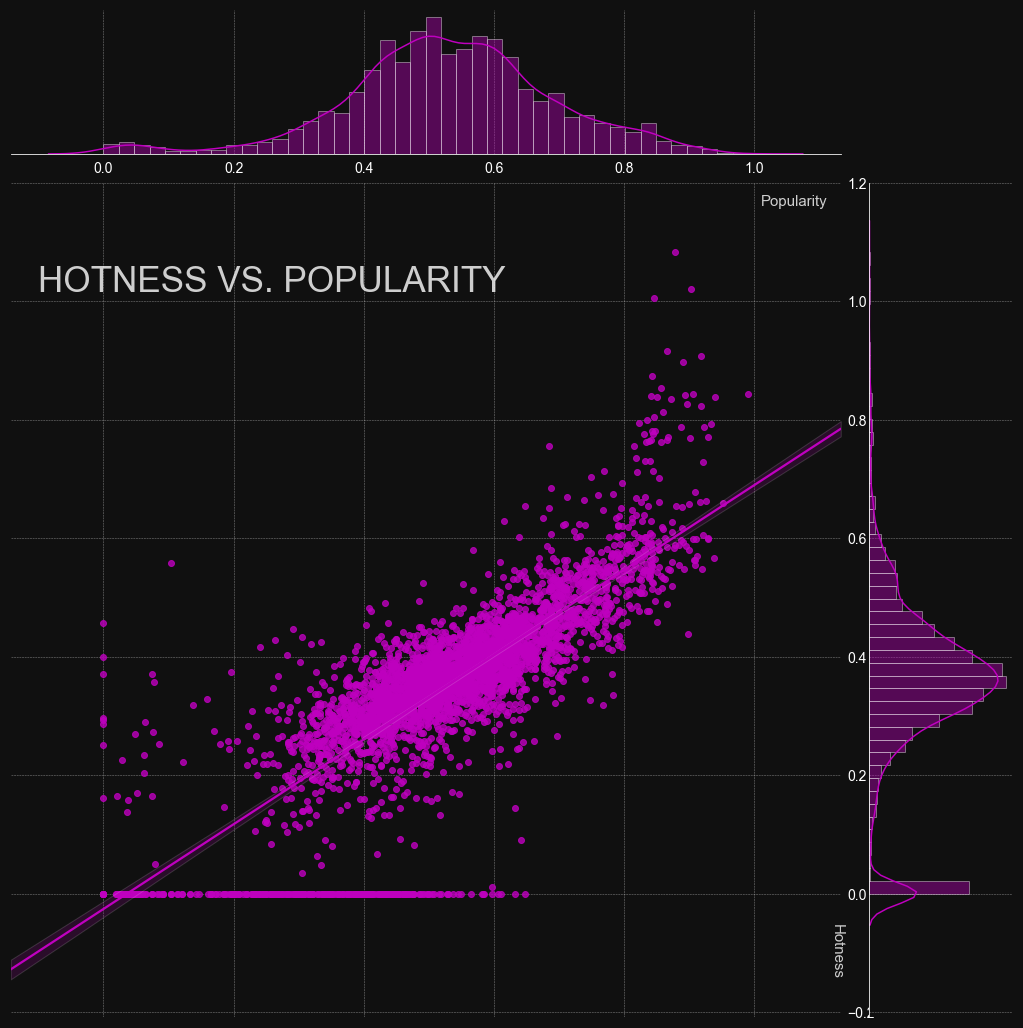

In [211]:
# represent_distribution(df_artist.hottness)
# represent_distribution()

def create_popularity_vis(figsize = (15,15)):
    sns.set_style(rc={"axes.facecolor": bg_color})
    sns.jointplot("familiarity", "hottness", data=df_artist, kind="reg", color='m',
                  height=figsize[0], )
    plt_captions('', '', '', labelsize=20)
    plt.annotate('Popularity', (1.01,1.18),
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, color='white', alpha=0.8, zorder=10)
    plt.annotate('Hotness', (1.115,-0.05), rotation=-90,
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, color='white', alpha=0.8, zorder=10)

    plt.annotate('Hotness vs. Popularity'.upper(), (-0.1,1.06),
            horizontalalignment='left', verticalalignment='top',
            fontsize=35, color='white', alpha=0.8, zorder=10)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                    right=True, labelright=True, left=False, labelleft=False)
    template_vis()

create_popularity_vis(figsize = (15,15))
plt.savefig('vis_popularity.png', facecolor=bg_color)
plt.show()

In [215]:
# mpl.rcParams['figure.figsize'] = (20,8)
# template_vis()
# # sns.pairplot(pd.DataFrame({'artist_popularity': artist_popularity,
# #                            'artist_hottness': artist_hottness}))
# plt.scatter(df_artist.familiarity, df_artist.hottness, edgecolors='w', s=50)
# plt_captions('Hottness vs. Popularity', 'Artist popularity', 'Artist hottness')
# plt.show()

In [218]:
# mpl.rcParams['figure.figsize'] = (20,8)
# df[col['artist']][:5]
# df[col['artist']].hist(bins=20);
# template_vis()

# Song characteristics

## Title, release, year

Далі зфокусуємо увагу на таких харакатеристиках пісні як рік випуску, назва пісні та назва альбому:

In [571]:
# print('First 5 examples')
# df[col['song']].head()

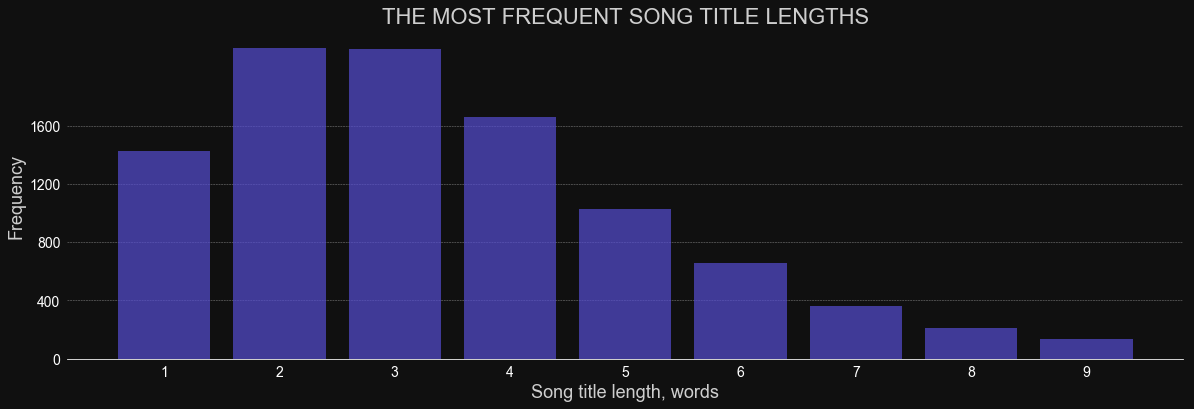

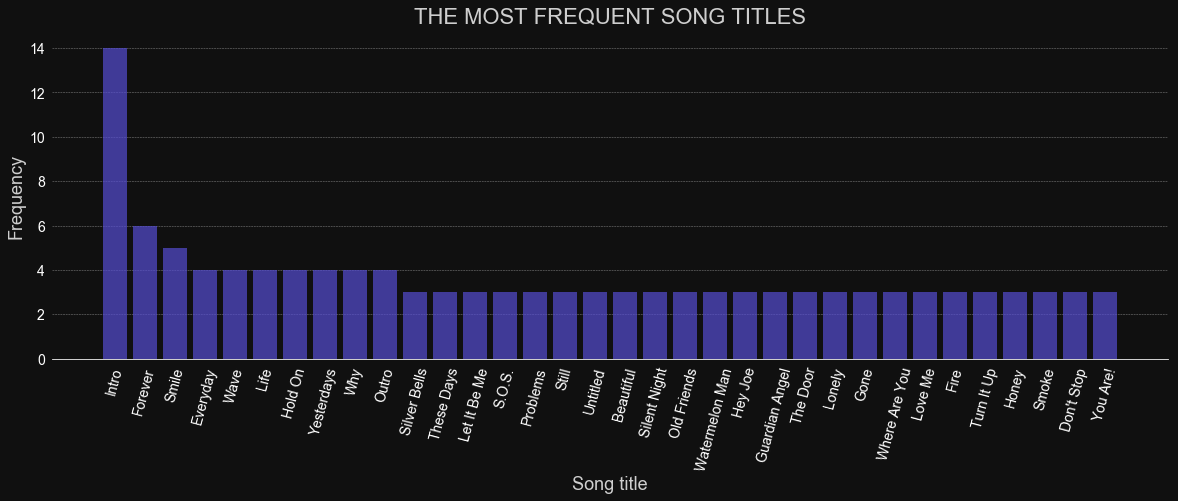

In [270]:
def create_freq_vis(by, aux, series, min_freq_to_show, title='', xlabel='', ylabel=''):
    frequency(df, by, aux, series, min_freq_to_show=min_freq_to_show)
    plt_captions(title, xlabel, ylabel)
    template_vis()
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().xaxis.grid(False)


create_freq_vis('title_tokenized_length', None, None, 100,
                'The most frequent song title lengths', 'Song title length, words', 'Frequency')
plt.yticks(np.arange(0,1800,400))
plt.xticks(np.arange(1,10))
plt.savefig('vis_freq_song_title_lengths.png', facecolor=bg_color)
plt.show()
create_freq_vis('title', None, None, 2,
                'The most frequent song titles', 'Song title', 'Frequency')
plt.yticks(np.arange(0,15,2))
plt.xticks(rotation=75)
plt.savefig('vis_freq_song_title.png', facecolor=bg_color)
plt.show()

Як видно зі статистики, серед назв пісень найчастіше (14 разів) в даних зустрічається назва `Intro` -- досить загальна назва, тому недивно. Також бачимо `Outro`; `Life`, `Forever`, `Smile` та інші загальні назви.

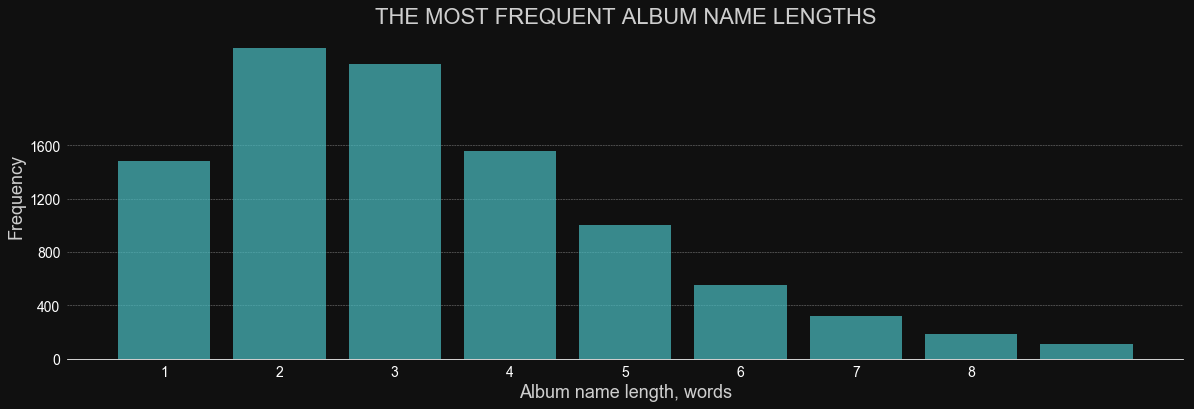

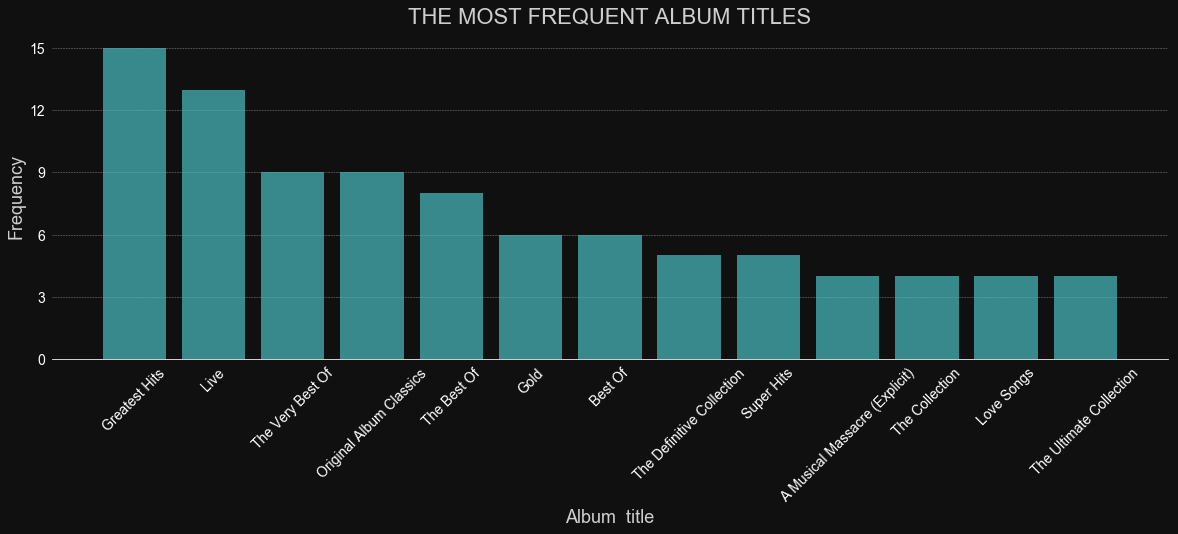

In [271]:
create_freq_vis('release_name_tokenized_length', None, None, 100,
                'The most frequent album name lengths', 'Album name length, words', 'Frequency')
plt.yticks(np.arange(0,1800,400))
plt.xticks(np.arange(1,9))
plt.savefig('vis_freq_album_title_lengths.png', facecolor=bg_color)
plt.show()

create_freq_vis('release_name', 'artist_name', None, 3,
                'The most frequent album titles', 'Album  title', 'Frequency')
plt.yticks(np.arange(0,18,3))
plt.xticks(rotation=45)
plt.savefig('vis_freq_album_title.png', facecolor=bg_color)
plt.show()

Тут можна помітити серед альбомів, які співпадають за назвою, в основном збірники пісень різних виконавців типу `Greatest Hits`, `The Best Of` і т.д. тобто назви оригінальні альбомів (на відміну від пісень) унікальні.

Подивимось, які слова в принципі найчастіше зучтрічаються в назвах пісень:

In [507]:
# words = list(itertools.chain(*[set(s) for s in df['release_name_tokenized'].values],
#                              *[set(s) for s in df['title_tokenized'].values]))
# words = Series(list(map(lambda s: s.capitalize(), words)))
# print(len(words))
# frequency(series=words, min_freq_to_show=200)
# plt_captions('The most frequent words used', 'Frequency', 'Word')
# plt.xticks(rotation=45)
# plt.show()

# _load_words_without_stopwords = True

# if _load_words_without_stopwords:
#     with open('words_without_stopwords.pkl', 'rb') as f:
#         words_without_stopwords = pickle.load(f)
# else:
#     words_without_stopwords = Series(remove_stopwords(words, [u'english',
#                                                               u'italian',
#                                                               u'german',
#                                                               u'dutch',
#                                                               u'portuguese',
#                                                               u'french']))
#     with open('words_without_stopwords.pkl', 'wb') as f:
#         pickle.dump(words_without_stopwords, f)

# frequency(series=words_without_stopwords, min_freq_to_show=100)
# plt_captions('The most frequent words used', 'Frequency', 'Word')
# # plt.yticks(np.arange(0,18,3))
# plt.xticks(rotation=45)
# plt.show()

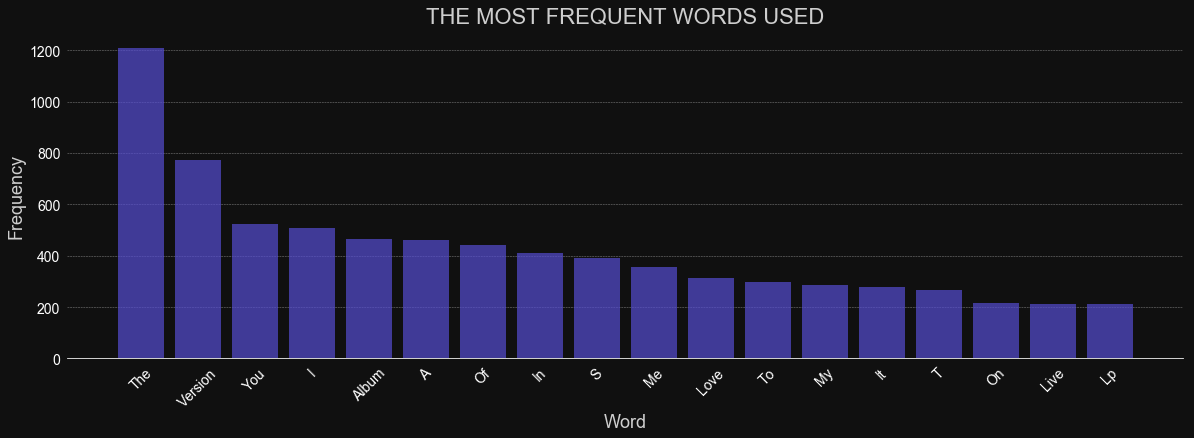

In [274]:
title_words = list(itertools.chain(*[set(s) for s in df['title_tokenized'].values]))
title_words = Series(list(map(lambda s: s.capitalize(), title_words)))
create_freq_vis(None, None, title_words, 200,
                'The most frequent words used', 'Word', 'Frequency')
plt.xticks(rotation=45)
plt.savefig('vis_freq_song_title_words.png', facecolor=bg_color)
plt.show()

Багато слів, що не несуть особливого сенсу (займенники, артиклі тощо). Тому приберемо їх.

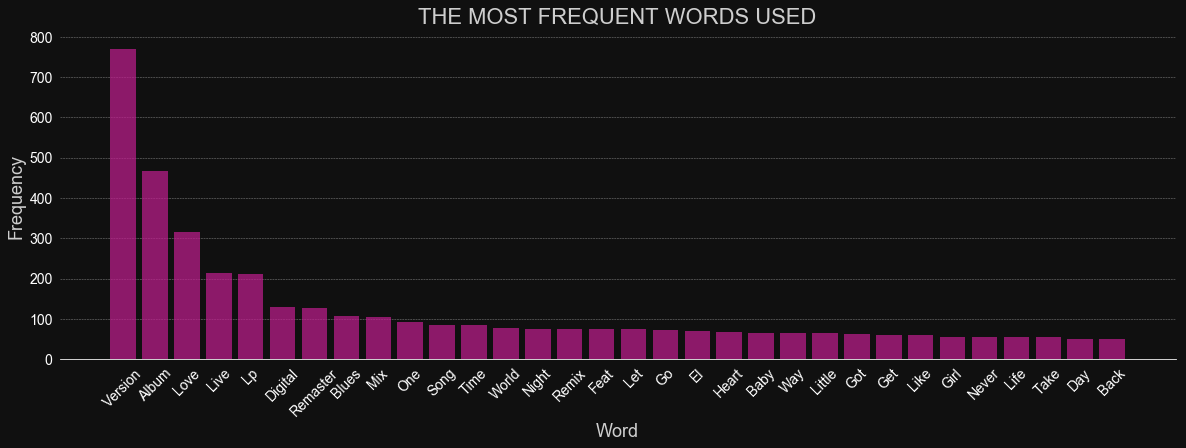

In [276]:
_load_title_words_without_stopwords = True

if _load_title_words_without_stopwords:
    with open('title_words_without_stopwords.pkl', 'rb') as f:
        title_words_without_stopwords = pickle.load(f)
else:
    title_words_without_stopwords = Series(remove_stopwords(title_words, [u'english',
                                                              u'italian',
                                                              u'german',
                                                              u'dutch',
                                                              u'portuguese',
                                                              u'french']))
    with open('title_words_without_stopwords.pkl', 'wb') as f:
        pickle.dump(title_words_without_stopwords, f)

create_freq_vis(None, None, title_words_without_stopwords, 50,
                'The most frequent words used', 'Word', 'Frequency')
plt.xticks(rotation=45)
plt.savefig('vis_freq_song_title_words.png', facecolor=bg_color)
plt.show()

Тож, не звертаючи уваги на `Version`, `Album` і тд, найчастіше слово `Love`. Напевне, частіше за все люди співають про кохання. Також багато `Blues`, `Mix`, `Remix`, що визначають стиль музики. Ще можемо помітити, що часто співають про час, світ, ніч, життя та дітей :))) Ймовірно, про дівчат співають більше, ніж про хлопців.

Аналіз текстів досить поверхневий, для більших інсайтів тут можна було б застосувати методи Natural Language Processing для знаходження, наприклад, кластерів назв за близкістю, але це виходить за рамки курсу.

Поглянемо, який розподіл кількості пісень (загальної та на одного виконавця) за роками.

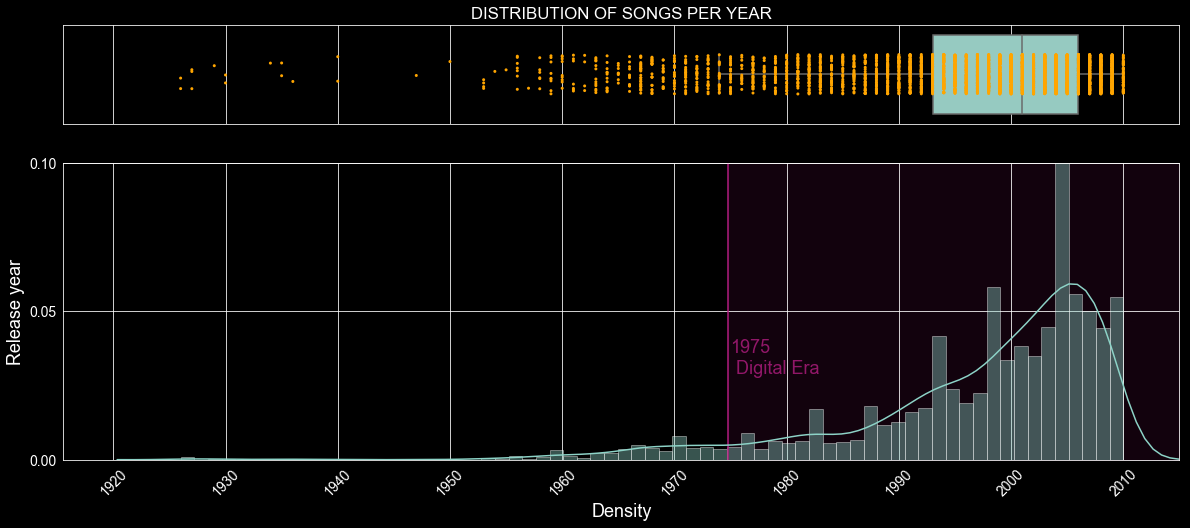

In [510]:
# Ready
represent_distribution(df.year.dropna(), kind='01', norm_hist=True, figsize=(20,8),
                       title='Distribution of songs per year'.upper())
plt.yticks([0,0.05,0.1])
plt.xticks(np.arange(1920,2020,10), rotation=45) #[1930,1940,1960,1970, 1990,2000]
plt_captions('', 'Density', 'Release year')
cl = '#B21D80'
plt.annotate('1975\n Digital Era', [1975, 0.029], fontsize=18, color=cl, alpha=0.8)
plt.fill_between([1974.8,2016], [0,0], [0.105,0.105], color=cl, alpha=0.1, zorder=0)
plt.vlines(1974.8, 0, 0.1, cl)
plt.ylim(top=0.1)
plt.xlim(right=2015)
plt.show()

Отже, більша частина припадає на 1970 -- 2010 рік. Якраз у 1975 починається цифрова ера, тому не дивно. Надалі розглядатимемо тільки цей період окремо від попереднього.

## Technical

/Users/Yaroslava/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Yaroslava/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


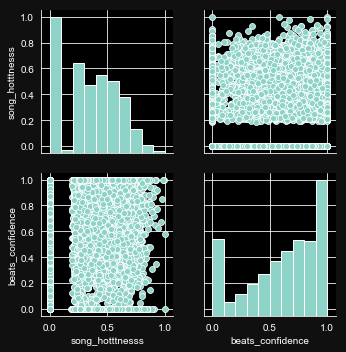

In [18]:
key = np.random.choice(col['tech'])
sns.pairplot(df[['song_hotttnesss', key]])

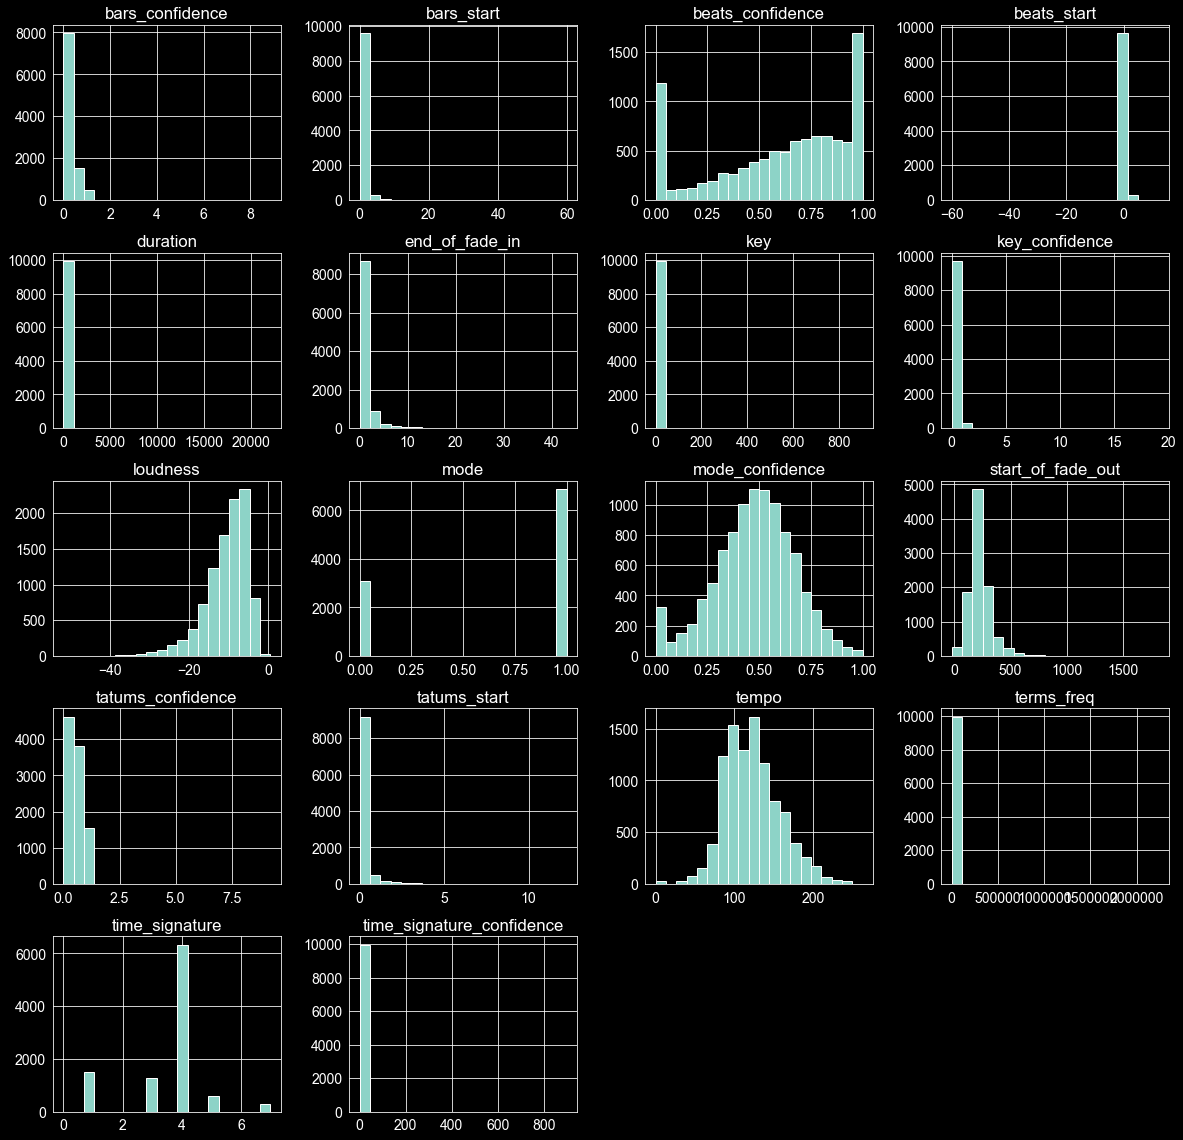

In [513]:
mpl.rcParams['figure.figsize'] = (20,20)
df[col['tech']].hist(bins=20);

/Users/Yaroslava/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


number of observations: 8000


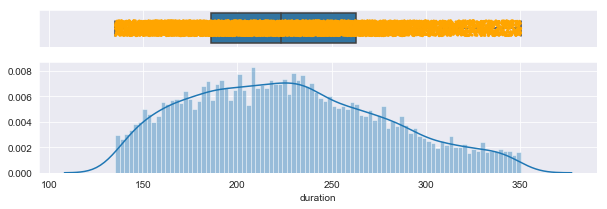

In [3]:
q10 = p_quantile(df.duration, 0.1)
q90 = p_quantile(df.duration, 0.9)
represent_distribution(df[df.duration<q90][df.duration>q10].duration)
# plt.xticks(np.arange(0, 400, 10), np.arange(0, 400, 50)/60)
# plt.show()

# Location

In [93]:
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
from plotly.graph_objs import *

In [103]:
verticies = Scattermapbox(
        lat = list(df.latitude),
        lon = list(df.longitude),
        mode = 'markers+text',
        marker = Marker(
            size = 14,
#             color = 1,
            opacity = 0.7
        ),
#         text = path,
#         textposition = 'top',
        textfont = dict(
            family = 'sans serif bold',
            size = 18,
            color = 'black'
        )
    )
mapbox_access_token = "pk.eyJ1IjoidmFsZW50eW4xOTk3IiwiYSI6ImNqNHlubm03cjFpc3EzM21nbW1rdGhvNmwifQ.xuQ0fbWNXjOi3y03MYbqAQ"
layout = Layout(
    title = 'Map',
    autosize = True,
    hovermode = 'closest',
    showlegend = False,
    height = 700,
    mapbox = dict(
        accesstoken = mapbox_access_token,
        bearing = 0,
#         center = dict(
#             lat = list(df.latitude),
#             lon = list(df.longitude),
#         ),
        pitch = 1,
        zoom = 3
    ),
)
# fig1 = dict(data=Data([verticies]), layout=l1)
plotly.offline.iplot(dict(data=[verticies], layout=layout), filename='Map')

In [88]:
col = ['latitude', 'location', 'longitude']
df[col]

,latitude,location,longitude
song.id,,,
SOMZWCG12A8C13C480,37.157357,California - LA,-63.933358
SOCIWDW12A8C13D406,35.149680,"Memphis, TN",-90.048920
SOXVLOJ12AB0189215,37.157357,Not available,-63.933358
SONHOTT12A8C13493C,37.157357,"London, England",-63.933358
SOFSOCN12A8C143F5D,37.157357,Not available,-63.933358
SOYMRWW12A6D4FAB14,37.157357,Not available,-63.933358
SOMJBYD12A6D4F8557,37.157357,Ohio,-63.933358
SOHKNRJ12A6701D1F8,37.157357,"Burlington, Ontario, Canada",-63.933358
SOIAZJW12AB01853F1,37.157357,Not available,-63.933358


In [65]:
# ['artist.hotttnesss', 'artist.id', 'artist.name', 'artist_mbtags',
# 'artist_mbtags_count', 'bars_confidence', 'bars_start',
# 'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
# 'familiarity', 'key', 'key_confidence', 'latitude', 'location',
# 'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
# 'release.name', 'similar', 'song.hotttnesss',
# 'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
# 'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
# 'title', 'year']

8116

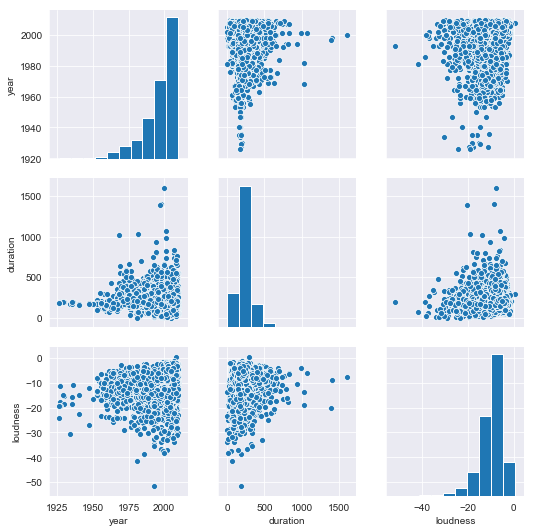

In [12]:
mpl.rcParams["figure.figsize"] = (20,20)
sns.pairplot(df[['year', 'duration', 'loudness']].dropna())
plt.show()